In [5]:
import pandas as pd
# tutorial https://bioservices.readthedocs.io/en/master/kegg_tutorial.html
from bioservices.kegg import KEGG
import re
import numpy as np
import warnings
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Read count data

In [6]:
df = pd.read_excel('../data/rnaseq/allGeneCounts_190709.xlsx', index_col=0).stack().reset_index()
df.columns = ['ref_genome_patric_id','strain','count']
df['replicate'] = [int(x.split('-')[0]) for x in df.strain]
df['strain'] = [x.split('-')[1].split('Aligned')[0] for x in df.strain]
df['strain_replicate'] = ['%s-%d'%(x,y) for x,y in zip(df.strain, df.replicate)]
df = df.replace({'PA14':'UCBPP-PA14'}).set_index('ref_genome_patric_id')
df.head()

,strain,count,replicate,strain_replicate
ref_genome_patric_id,,,,
fig|287.6770.peg.1,F22031,5488.498015,1,F22031-1
fig|287.6770.peg.1,F30658,7013.428883,1,F30658-1
fig|287.6770.peg.1,F34365,8189.181280,1,F34365-1
fig|287.6770.peg.1,M1608,7265.424672,1,M1608-1
fig|287.6770.peg.1,M37351,6731.131164,1,M37351-1


## PCA

<ipython-input-7-5aa64a8ca67c>:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.rhamno3cats = df.rhamn3cats.astype("category")


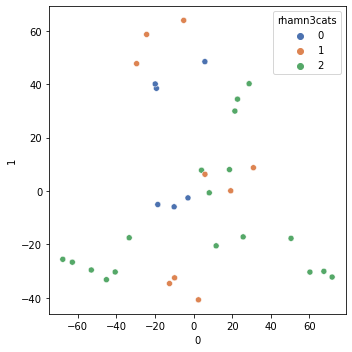

In [7]:
df = pd.read_excel('../data/rnaseq/allGeneCounts_190709.xlsx', index_col=0).stack().reset_index()
df.columns = ['ref_genome_patric_id','strain','count']
df['replicate'] = [int(x.split('-')[0]) for x in df.strain]
df['strain'] = [x.split('-')[1].split('Aligned')[0] for x in df.strain]
df['strain_replicate'] = ['%s-%d'%(x,y) for x,y in zip(df.strain, df.replicate)]
df_strain_by_rhamnolipid_production = pd.read_excel('../data/rhamnolipids/rhamnMat.xlsx')[['strain','rhamn3cats']]
df = pd.merge(df, df_strain_by_rhamnolipid_production, left_on=['strain'], right_on=['strain'], how='left')
df.rhamno3cats = df.rhamn3cats.astype("category")

df_X = pd.pivot_table(data=df, index='strain_replicate', columns='ref_genome_patric_id', values='count', aggfunc='mean')
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=2))])
projected = pipeline.fit_transform(df_X)
df2plot = pd.DataFrame(projected)
df2plot['rhamn3cats'] = list(df[['strain_replicate','rhamn3cats']].drop_duplicates().set_index('strain_replicate').loc[df_X.index,'rhamn3cats'])

fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=df2plot, x=0, y=1, hue='rhamn3cats', palette="deep")

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('pca.svg', dpi=600)

In [8]:
pipeline.named_steps['pca'].explained_variance_ratio_

array([0.194072  , 0.15549086])

# Read orthologue comparisons

In [15]:
df_ort = pd.read_excel('../data/rnaseq/genome_comparison-PA14jbx.xlsx', skiprows=[0])

# bi and both coverage > 0.9
df_ort = df_ort[(df_ort['comp_genome_1_hit']=='bi (<->)')&(df_ort['comp_genome_1_percent_identity']>0.9)&(df_ort['comp_genome_1_seq_coverage']>0.9)]

df_ort = df_ort[['ref_genome_patric_id','comp_genome_1_gene_name','comp_genome_1_locus_tag']].set_index('ref_genome_patric_id')

df_ort.head()

,comp_genome_1_gene_name,comp_genome_1_locus_tag
ref_genome_patric_id,,
fig|287.6770.peg.1,dnaA,PA14_00010
fig|287.6770.peg.2,dnaN,PA14_00020
fig|287.6770.peg.3,recF,PA14_00030
fig|287.6770.peg.4,gyrB,PA14_00050
fig|287.6770.peg.6,NaN,PA14_00060


In [16]:
df = pd.merge(df, df_ort, left_index=True, right_index=True, how='left')
df.columns = ['Strain','Count','Replicate','Gene','LocusTag']
df.loc[~df.Gene.notnull(), 'Gene'] = df.loc[~df.Gene.notnull(),'LocusTag']
df.loc[~df.Gene.notnull(), 'Gene'] = df[~df.Gene.notnull()].index
df.index.name = 'patric_id'
df.to_csv('processed_count_table_0915.csv')
df.head()

,Strain,Count,Replicate,Gene,LocusTag
patric_id,,,,,
fig|287.6770.peg.1,F22031,5488.498015,1,dnaA,PA14_00010
fig|287.6770.peg.1,F30658,7013.428883,1,dnaA,PA14_00010
fig|287.6770.peg.1,F34365,8189.181280,1,dnaA,PA14_00010
fig|287.6770.peg.1,M1608,7265.424672,1,dnaA,PA14_00010
fig|287.6770.peg.1,M37351,6731.131164,1,dnaA,PA14_00010


# Map genes to pathways

In [21]:
k = KEGG()
KEGG_PA_strains = ["pae", "paev", "paei", "pau",  "pap",
                   "pag", "paf",  "pnc",  "paeb", "pdk",
                   "psg", "prp",  "paep", "paer", "paem",
                   "pael","paes", "paeu", "paeg", "paec",
                   "paeo"]

dict_PAgene_KEGGpathway = {} # mappnig of PA gene name to pathway
KEGGpathway_Legend = {} # legend of KEGG pathways

count = 0
lines2append = []
PA_genes_all = dict(zip(df[['Gene','LocusTag']].drop_duplicates().Gene,df[['Gene','LocusTag']].drop_duplicates().LocusTag))
PA_genes_all = {k:v for k,v in PA_genes_all.items() if str(v)!='nan'}
for gene_id, PA14_locus in PA_genes_all.items():
    if (count % 100 == 0):
        print(count)
        
    gene_id_suffix_removed = re.sub(r'_\d+$', '', gene_id)
    curr_line = [gene_id, gene_id_suffix_removed, PA14_locus]
    for strain_to_map in KEGG_PA_strains:
        try:
            res = k.get_pathway_by_gene(gene_id_suffix_removed, strain_to_map)
            if (res is None) and (strain_to_map == "pau"):
                res = k.get_pathway_by_gene(PA14_locus, strain_to_map)
            if res is not None:
                curr_line.append((',').join(list(res.keys())))
                KEGGpathway_Legend = {**KEGGpathway_Legend, **res}
            else:
                curr_line.append('')
        except:
            curr_line.append('')
    lines2append.append(curr_line)
    print(curr_line)
    count += 1
    
df_kegg_pathway = pd.DataFrame(lines2append, index = PA_genes_all, columns = ["Gene", "Gene_wo_suffix", "PA14_locus"]+KEGG_PA_strains)
df_kegg_pathway.to_csv('kegg_pathway_mapping_raw.csv')

df_KEGGpathway_legend = pd.DataFrame.from_dict(KEGGpathway_Legend, orient='index')
df_KEGGpathway_legend.columns = ['Name']
df_KEGGpathway_legend.to_csv('KEGGpathway_Legend.csv')

# Post-process

In [39]:
df_kegg_pathway = pd.read_csv('kegg_pathway_mapping_raw.csv', index_col=0).fillna('')
df_kegg_pathway = df_kegg_pathway.drop(['Gene_wo_suffix','PA14_locus'], axis=1)
df_kegg_pathway.head()

,pae,paev,paei,pau,pap,pag,paf,pnc,paeb,pdk,...,prp,paep,paer,paem,pael,paes,paeu,paeg,paec,paeo
Gene,,,,,,,,,,,,,,,,,,,,,
dnaA,pae02020,paev02020,paei02020,pau02020,pap02020,pag02020,paf02020,pnc02020,paeb02020,pdk02020,...,,,,,,paes02020,paeu02020,,paec02020,paeo02020
glyQ,pae00970,paev00970,paei00970,pau00970,pap00970,pag00970,paf00970,pnc00970,,pdk00970,...,,,,,,,paeu00970,,paec00970,paeo00970
PA14_01130,,,,,,,,,,,...,,,,,,,,,,
sltB1,,,,,,,,,,,...,,,,,,,,,,
PA14_12090,,,,,,,,,,,...,,,,,,,,,,


In [40]:
# get unique pathway ids
unique_pathways = []
for strain in df_kegg_pathway.columns:
    unique_pathways.extend([x for x in list(set(df_kegg_pathway[strain].str.cat(sep=',').split(','))) if x != ''])

In [41]:
df_KEGGpathway_legend_reverse = {}
for name in df_KEGGpathway_legend.Name:
    df_KEGGpathway_legend_reverse[name] = (',').join(list(df_KEGGpathway_legend[df_KEGGpathway_legend.Name==name].index))
df_KEGGpathway_legend_reverse = pd.DataFrame.from_dict(df_KEGGpathway_legend_reverse, orient='index', columns=['pathway_id'])

res = []
for pids in df_KEGGpathway_legend_reverse['pathway_id']:
    for pid in pids.split(','):
        if 'pau' in pid:
            res.append(pid)
            break
df_KEGGpathway_legend_reverse['pathway_id_PA14'] = res
df_KEGGpathway_legend_reverse.head()

,pathway_id,pathway_id_PA14
Two-component system,"pae02020,paev02020,paei02020,pau02020,pap02020...",pau02020
Aminoacyl-tRNA biosynthesis,"pae00970,paev00970,paei00970,pau00970,pap00970...",pau00970
Peptidoglycan biosynthesis,"pae00550,pau00550,pap00550,pag00550,paf00550,p...",pau00550
Metabolic pathways,"pae01100,pau01100,pap01100,pag01100,paf01100,p...",pau01100
Lipoic acid metabolism,"pae00785,paev00785,paei00785,pau00785,pap00785...",pau00785


In [134]:
df_KEGGpathway_legend_reverse[df_KEGGpathway_legend_reverse.pathway_id_PA14.isin(['pau00902','pau00450','pau00261','pau01053','pau00053','pau01502','pau00471','pau00920'])]

,pathway_id,pathway_id_PA14
Sulfur metabolism,"pau00920,pae00920,paev00920,paei00920,pap00920...",pau00920
Vancomycin resistance,"pau01502,pae01502,paev01502,paei01502,pap01502...",pau01502
Ascorbate and aldarate metabolism,"pau00053,pnc00053",pau00053
Selenocompound metabolism,"pae00450,paev00450,paei00450,pau00450,pap00450...",pau00450
Monobactam biosynthesis,"pae00261,paev00261,paei00261,pau00261,pap00261...",pau00261
D-Glutamine and D-glutamate metabolism,"pau00471,pae00471,paev00471,paei00471,pap00471...",pau00471
Biosynthesis of siderophore group nonribosomal peptides,"pae01053,pau01053,pag01053,paf01053,pap01053,p...",pau01053


In [133]:
df_KEGGpathway_legend_reverse[df_KEGGpathway_legend_reverse.pathway_id_PA14.isin(['pau00500','pau00525','pau00523','pau00405','pau00040','pau02025','pau02024'])]

,pathway_id,pathway_id_PA14
Quorum sensing,"paev02024,paei02024,pau02024,pap02024,paf02024...",pau02024
Biofilm formation - Pseudomonas aeruginosa,"pae02025,pau02025,pag02025,paf02025,pnc02025,p...",pau02025
Pentose and glucuronate interconversions,"pau00040,pae00040,paeb00040,paev00040,paei0004...",pau00040
Starch and sucrose metabolism,"pae00500,paev00500,paei00500,pau00500,pap00500...",pau00500
Phenazine biosynthesis,"pae00405,pau00405,pag00405,paf00405,pnc00405,p...",pau00405
Polyketide sugar unit biosynthesis,"paeu00523,pae00523,pau00523,pag00523,paf00523,...",pau00523
Acarbose and validamycin biosynthesis,"pae00525,pau00525,pag00525,paf00525,pnc00525,p...",pau00525


In [43]:
# convert to square matrix
row = []
for gid in df_kegg_pathway.index:
    pathways_of_gid = ((',').join([x.strip() for x in list(df_kegg_pathway.loc[gid]) if x != ''])).split(',')
    row.append([1 if pid in pathways_of_gid else 0 for pid in unique_pathways])
df_kegg_pathway_sqm = pd.DataFrame(row,index=df_kegg_pathway.index,columns=unique_pathways)
df_kegg_pathway_sqm.head()

,pae00561,pae00523,pae00790,pae00520,pae00401,pae00500,pae00230,pae00480,pae00450,pae00730,...,paeo00380,paeo00562,paeo03070,paeo00640,paeo00040,paeo00280,paeo03420,paeo00332,paeo00680,paeo00540
Gene,,,,,,,,,,,,,,,,,,,,,
dnaA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
glyQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PA14_01130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sltB1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PA14_12090,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
df_kegg_pathway_sqm_simplified = pd.DataFrame(index = df_kegg_pathway_sqm.index, columns = df_KEGGpathway_legend_reverse.pathway_id_PA14)
for index in df_KEGGpathway_legend_reverse.index:
    pid_all = df_KEGGpathway_legend_reverse.loc[index,'pathway_id'].split(',')
    df_kegg_pathway_sqm_curr = df_kegg_pathway_sqm[set(pid_all).intersection(df_kegg_pathway_sqm.columns)]
    num_of_presence = list(df_kegg_pathway_sqm_curr.sum(axis=1).values)
    df_kegg_pathway_sqm_simplified[df_KEGGpathway_legend_reverse.loc[index,'pathway_id_PA14']] = [1 if x >0.5 else 0 for x in num_of_presence]

In [56]:
# remove rows and columns that have only zeros
df_kegg_pathway_sqm_simplified = df_kegg_pathway_sqm_simplified.loc[~(df_kegg_pathway_sqm_simplified==0).all(axis=1)]
df_kegg_pathway_sqm_simplified = df_kegg_pathway_sqm_simplified.loc[:, (df_kegg_pathway_sqm_simplified != 0).any(axis=0)]  
df_kegg_pathway_sqm_simplified.head()

pathway_id_PA14,pau02020,pau00970,pau00550,pau01100,pau00785,pau01240,pau03030,pau03430,pau03440,pau00860,...,pau00622,pau00471,pau01053,pau00600,pau00332,pau00791,pau00473,pau00523,pau00525,pau03020
Gene,,,,,,,,,,,,,,,,,,,,,
dnaA,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
glyQ,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dacC,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lipB,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
holA,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
df_kegg_pathway_sqm_simplified.to_csv('kegg_pathway_mapping_square_form_simplified.csv')